# Part 4, Model 1B NN: Neural Network classification using the fundus, optic cup and optic disk images of the eye

In [1]:
# omg im alive

%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-03-11 16:40:04.608952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 16:40:04.609006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 16:40:04.610596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 16:40:04.619970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 16:40:05.439508: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data[data['fundus_oc_seg'].notnull() & data['fundus_od_seg'].notnull()].info()

print(data['fundus_oc_seg'].notnull().value_counts())

data[data['fundus_oc_seg'].notnull()]

<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 4546 to 12048
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     3102 non-null   object 
 1   types                     3102 non-null   int64  
 2   type_expanded             1848 non-null   object 
 3   isColor                   3102 non-null   int64  
 4   original_name             3102 non-null   object 
 5   patient_id                488 non-null    object 
 6   fundus                    3102 non-null   object 
 7   fundus_od_seg             3102 non-null   object 
 8   fundus_oc_seg             3102 non-null   object 
 9   bv_seg                    0 non-null      object 
 10  artery_seg                0 non-null      object 
 11  vein_seg                  0 non-null      object 
 12  oct                       44 non-null     object 
 13  oct_oc_seg                44 non-null     object 
 14  oct_od_se

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
4546,ORIGA-1,0,NaN,1,001.jpg,NaN,/full-fundus/ORIGA-1.png,/optic-disc/ORIGA-1.png,/optic-cup/ORIGA-1.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,ORIGA-2,0,NaN,1,002.jpg,NaN,/full-fundus/ORIGA-2.png,/optic-disc/ORIGA-2.png,/optic-cup/ORIGA-2.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,ORIGA-3,0,NaN,1,003.jpg,NaN,/full-fundus/ORIGA-3.png,/optic-disc/ORIGA-3.png,/optic-cup/ORIGA-3.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,ORIGA-4,0,NaN,1,004.jpg,NaN,/full-fundus/ORIGA-4.png,/optic-disc/ORIGA-4.png,/optic-cup/ORIGA-4.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,ORIGA-5,0,NaN,1,005.jpg,NaN,/full-fundus/ORIGA-5.png,/optic-disc/ORIGA-5.png,/optic-cup/ORIGA-5.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,PAPILA-484,0,Healthy,1,289,PAPILA-289,/full-fundus/PAPILA-484.png,/optic-disc/PAPILA-484.png,/optic-cup/PAPILA-484.png,NaN,...,NaN,0.75,-1.5,93,1,10,,531,22.31,
12045,PAPILA-485,0,Healthy,1,290,PAPILA-290,/full-fundus/PAPILA-485.png,/optic-disc/PAPILA-485.png,/optic-cup/PAPILA-485.png,NaN,...,NaN,0.25,-0.25,160,1,19,,573,22.01,
12046,PAPILA-486,0,Healthy,1,291,PAPILA-291,/full-fundus/PAPILA-486.png,/optic-disc/PAPILA-486.png,/optic-cup/PAPILA-486.png,NaN,...,NaN,1.5,-1.25,76,0,14,,443,23.51,
12047,PAPILA-487,0,Healthy,1,292,PAPILA-292,/full-fundus/PAPILA-487.png,/optic-disc/PAPILA-487.png,/optic-cup/PAPILA-487.png,NaN,...,NaN,1.25,-0.75,79,0,9,,479,23.84,


In [8]:
# know column type
data['fundus_oc_seg'].dtype

dtype('O')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [10]:
data['fundus_oc_seg'][12044]

'/optic-cup/PAPILA-484.png'

In [11]:
data['fundus_od_seg'][12044]

'/optic-disc/PAPILA-484.png'

In [12]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


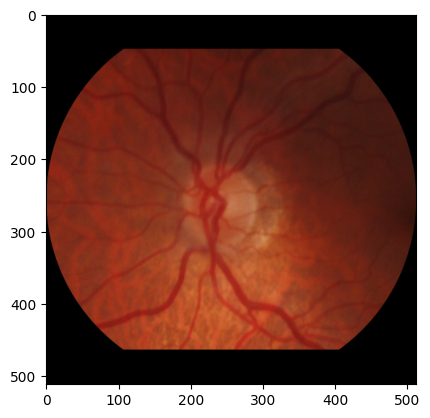

optic-cup/optic-cup/PAPILA-484.png


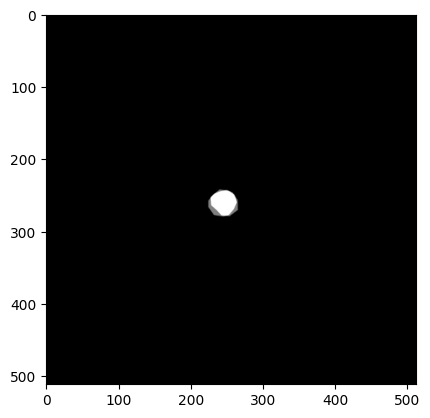

optic-disc/optic-disc/PAPILA-484.png


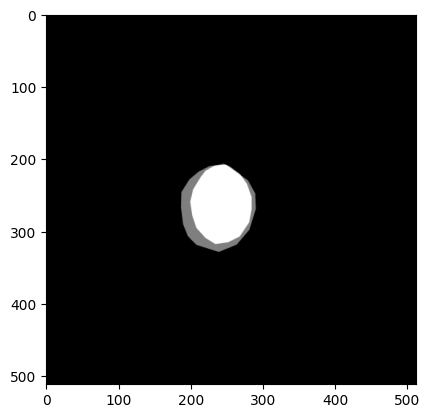

In [13]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])
viewOpticDisc(data['fundus_od_seg'][12044])

In [14]:
data["types"].value_counts()

types
 0    7549
 1    4767
-1     133
Name: count, dtype: int64

In [15]:
data["types"].value_counts().sum()

12449

In [16]:
#removing the patients with no fundus classification and with fundus classification -1 instead of 0,1
data = data [

    (data['fundus'].notnull()) &
    (data['fundus_oc_seg'].notnull()) & 
    (data['fundus_od_seg'].notnull()) & (data['types'] != -1)
]

fundus_subset = data[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3034 entries, 4546 to 12048
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   types          3034 non-null   object
 1   fundus         3034 non-null   object
 2   fundus_oc_seg  3034 non-null   object
 3   fundus_od_seg  3034 non-null   object
 4   names          3034 non-null   object
 5   combined       3034 non-null   object
dtypes: object(6)
memory usage: 165.9+ KB


/tmp/ipykernel_13207/1673553536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_13207/1673553536.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_13207/1673553536.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [17]:
fundus_subset['types'].value_counts()

types
0    2310
1     724
Name: count, dtype: int64

In [18]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
4546,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
4547,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,ORIGA-2.png
4548,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,ORIGA-3.png
4549,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,ORIGA-4.png
4550,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,ORIGA-5.png
...,...,...,...,...,...,...
12044,0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,PAPILA-484.png
12045,0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,PAPILA-485.png
12046,0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,PAPILA-486.png
12047,0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,PAPILA-487.png


In [19]:
fundus_subset[fundus_subset['combined'] == 'G1020-107.png']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
7378,1,/full-fundus/G1020-107.png,Not Visible,/optic-disc/G1020-107.png,G1020-107,G1020-107.png


In [20]:
#show me the instances in fundus column that say Not Visible

fundus_subset[fundus_subset['fundus'] == 'Not Visible']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined


In [21]:
#show me the instances in fundus_oc_seg column that say Not Visible

fundus_subset[fundus_subset['fundus_oc_seg'] == 'Not Visible']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
7276,0,/full-fundus/G1020-5.png,Not Visible,/optic-disc/G1020-5.png,G1020-5,G1020-5.png
7278,0,/full-fundus/G1020-7.png,Not Visible,/optic-disc/G1020-7.png,G1020-7,G1020-7.png
7279,0,/full-fundus/G1020-8.png,Not Visible,/optic-disc/G1020-8.png,G1020-8,G1020-8.png
7284,1,/full-fundus/G1020-13.png,Not Visible,/optic-disc/G1020-13.png,G1020-13,G1020-13.png
7285,1,/full-fundus/G1020-14.png,Not Visible,/optic-disc/G1020-14.png,G1020-14,G1020-14.png
...,...,...,...,...,...,...
8256,1,/full-fundus/G1020-985.png,Not Visible,/optic-disc/G1020-985.png,G1020-985,G1020-985.png
8261,0,/full-fundus/G1020-990.png,Not Visible,/optic-disc/G1020-990.png,G1020-990,G1020-990.png
8275,1,/full-fundus/G1020-1004.png,Not Visible,/optic-disc/G1020-1004.png,G1020-1004,G1020-1004.png
8281,0,/full-fundus/G1020-1010.png,Not Visible,/optic-disc/G1020-1010.png,G1020-1010,G1020-1010.png


In [22]:
#show me the instances in fundus_od_seg column that say Not Visible

fundus_subset[fundus_subset['fundus_od_seg'] == 'Not Visible']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined


In [23]:
# remove instances that say Not Visible in fundus column
fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

In [24]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
4546,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
4547,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,ORIGA-2.png
4548,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,ORIGA-3.png
4549,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,ORIGA-4.png
4550,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,ORIGA-5.png
...,...,...,...,...,...,...
12044,0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,PAPILA-484.png
12045,0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,PAPILA-485.png
12046,0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,PAPILA-486.png
12047,0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,PAPILA-487.png


In [25]:
fundus_subset[["types"]].value_counts()

types
0        2140
1         665
Name: count, dtype: int64

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming fundus_subset is your DataFrame and 'types' is the column with labels
# Also assuming you have 'fundus_subset_random' DataFrame created earlier

testSize = 500
valSize = 200

# Calculate the number of samples for each class
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

print('Total fundus images to  be used: ', glaucomaCount + healthyCount)

# Set the random seed for reproducibility
random_state = 1

# Create StratifiedShuffleSplit instance for test set
stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

# Create StratifiedShuffleSplit instance for validation set
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set, train_set['types']):
    train = train_set.iloc[train_index]
    val = train_set.iloc[val_index]

# Now train_set_final, val_set, and test_set contain the stratified splits

# Print the counts for each set
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

# You can access the features and labels as needed:
train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140
Total fundus images to  be used:  2805

Train set size: 2105
Validation set size: 200
Test set size: 500


In [27]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  2105
Test Size:  500


In [28]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-11 16:40:07.164024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:40:07.231812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:40:07.232541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


# Set target size and batch size for data generator
target = 224
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-03-11 16:40:07.254405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:40:07.254966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:40:07.255371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:40:07.421356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:40:07.421997: I external/local_xla/xla/stream_executor

Found 2105 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2105 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [31]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=False, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 2105 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [32]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Concatenate, GlobalAveragePooling2D
from keras.applications import MobileNetV3Small
from keras.optimizers import Adam

# Define input shapes
input_shape = (224, 224, 3)

# Create a base model for feature extraction
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')

# Unfreeze some of the later layers of the base model
for layer in base_model.layers[-20:]:  # Adjust this value as needed
    if not isinstance(layer, BatchNormalization):  # Skip unfreezing Batch Normalization layers
        layer.trainable = True

# Define the three inputs
input_img1 = Input(shape=input_shape, name='input_image_1')
input_img2 = Input(shape=input_shape, name='input_image_2')
input_img3 = Input(shape=input_shape, name='input_image_3')

# Use the base model for feature extraction from each input
# Note: If you're sharing the base model, you don't need to flatten after pooling='avg' is used
x1 = base_model(input_img1)
x2 = base_model(input_img2)
x3 = base_model(input_img3)

# Concatenate the features extracted from each input
concatenated = Concatenate()([x1, x2, x3])

# Add a dense layer with Batch Normalization and Dropout
x = Dense(512, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Additional dense layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[input_img1, input_img2, input_img3], outputs=output)

# Compile the model with a smaller learning rate and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image_1 (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_image_2 (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_image_3 (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 MobilenetV3small (Function  (None, 576)                  939120    ['input_image_1[0][0]',       
 al)                                                                 'input_image_2[0][0]',   

In [33]:
def generate_combined_batches(gen1, gen2, gen3):
    while True:
        batch1 = gen1.next()
        batch2 = gen2.next()
        batch3 = gen3.next()

        yield [batch1[0], batch2[0], batch3[0]], batch1[1]  # Assuming labels are the same across batches


# Example of how to use the generator
train_generator = generate_combined_batches(trainGen1, trainGen2, trainGen3)
val_generator = generate_combined_batches(valGen1, valGen2, valGen3)

# Train the model
history = model.fit(train_generator, validation_data=val_generator, steps_per_epoch=len(trainGen1), validation_steps=len(valGen1), epochs=10)

Epoch 1/10


2024-03-11 16:40:39.606667: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-11 16:40:40.008586: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 16:40:41.320853: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 16:40:45.576052: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1e1c8b5590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 16:40:45.576093: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-03-11 16:40:45.600342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710160845.710137   14050 devic

264/264 [==============================] - 171s 518ms/step - loss: 0.9215 - accuracy: 0.5539 - val_loss: 0.5662 - val_accuracy: 0.7550
Epoch 2/10
264/264 [==============================] - 49s 188ms/step - loss: 0.8030 - accuracy: 0.6076 - val_loss: 0.7691 - val_accuracy: 0.7650
Epoch 3/10
264/264 [==============================] - 49s 186ms/step - loss: 0.7322 - accuracy: 0.6456 - val_loss: 1.0717 - val_accuracy: 0.7650
Epoch 4/10
264/264 [==============================] - 62s 236ms/step - loss: 0.6551 - accuracy: 0.6855 - val_loss: 1.2497 - val_accuracy: 0.7650
Epoch 5/10
264/264 [==============================] - 69s 223ms/step - loss: 0.6255 - accuracy: 0.7017 - val_loss: 1.3251 - val_accuracy: 0.7650
Epoch 6/10
264/264 [==============================] - 64s 206ms/step - loss: 0.5923 - accuracy: 0.7211 - val_loss: 0.8229 - val_accuracy: 0.7700
Epoch 7/10
264/264 [==============================] - 64s 207ms/step - loss: 0.5719 - accuracy: 0.7382 - val_loss: 0.6081 - val_accuracy: 0.

In [34]:
def generate_evaluation_batches(gen1, gen2, gen3):
    while True:
        batch1 = gen1.next()
        batch2 = gen2.next()
        batch3 = gen3.next()

        # Yield a list of numpy arrays (one for each input) and the labels
        yield [batch1[0], batch2[0], batch3[0]], batch1[1]  # Assuming labels are the same across batches

# Create evaluation generators
val_evaluation_generator = generate_evaluation_batches(valGen1, valGen2, valGen3)
test_evaluation_generator = generate_evaluation_batches(testGen1, testGen2, testGen3)

# Determine the number of steps for each evaluation
val_steps = len(valGen1)
test_steps = len(testGen1)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_evaluation_generator, steps=val_steps)
print('Validation accuracy:', val_accuracy)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_evaluation_generator, steps=test_steps)
print('Test accuracy:', test_accuracy)

25/25 [==============================] - 13s 142ms/step - loss: 0.6399 - accuracy: 0.7750
Validation accuracy: 0.7749999761581421
63/63 [==============================] - 15s 235ms/step - loss: 0.7593 - accuracy: 0.7400
Test accuracy: 0.7400000095367432


In [35]:
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Generate Predictions
# Note: Adjust 'predict' according to how your generators are set up. This might require custom handling.
predictions = model.predict(test_evaluation_generator, steps=test_steps)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Step 2: Retrieve Actual Labels
# Assuming your test generator returns labels in the correct order and format
actual_labels = []
for _, labels in test_evaluation_generator:
    actual_labels.extend(labels)
    if len(actual_labels) >= test_steps * batchSize:
        break
actual_labels = np.array(actual_labels)[:len(predicted_classes)]  # Ensure same length as predictions

# Step 3: Compute Classification Report
report = classification_report(actual_labels, predicted_classes)
print(report)

# Step 4: Compute Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels, predicted_classes)
print(conf_matrix)

63/63 [==============================] - 21s 300ms/step
              precision    recall  f1-score   support

         0.0       0.76      0.95      0.85       381
         1.0       0.24      0.05      0.08       119

    accuracy                           0.74       500
   macro avg       0.50      0.50      0.46       500
weighted avg       0.64      0.74      0.66       500

[[362  19]
 [113   6]]
